# Задача
Взять страницу Вконтакте, собрать по ней таблицу с датой постов и количеством лайков и ответить на вопрос: что больше всего влияет на количество лайков: время суток публикации, день недели или промежуток между постами?

In [79]:
import requests
import os
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

## Парсинг данных из ВК
Сначала вытащим из ВК необходимые данные. Моя страница не активна, так что возьмём последние 1000 постов из группы Северодвинск life (https://vk.com/severodvinsk_life)

In [11]:
# Чтение токена доступа из файла
with open('token.txt', 'r') as file:
    access_token = file.read().strip()  # Читаем токен и убираем лишние пробелы и символы новой строки
    
# ID группы или пользователя
owner_id = '-39644772'

# Параметры для запроса
count = 100  # Максимальное количество постов за один запрос
total_posts = 1000  # Общее количество постов, которые нужно получить
offset = 0   # Начальное значение offset

In [12]:
# Списки для хранения данных
post_times = []
like_counts = []

while len(post_times) < total_posts:
    # URL для запроса
    url = f'https://api.vk.com/method/wall.get?owner_id={owner_id}&count={count}&offset={offset}&access_token={access_token}&v=5.131'
    
    # Выполняем запрос
    response = requests.get(url)
    data = response.json()

    # Проверяем наличие ошибок
    if 'error' in data:
        print('Ошибка:', data['error']['error_msg'])
        break

    # Извлекаем посты
    posts = data['response']['items']
    
    # Если постов больше нет, выходим из цикла
    if not posts:
        break

    # Извлекаем время и количество лайков
    for post in posts:
        post_times.append(post['date'])  # Время поста (timestamp)
        like_counts.append(post['likes']['count'])  # Количество лайков
        
        # Проверяем, достигли ли мы лимита
        if len(post_times) >= total_posts:
            break

    # Увеличиваем offset для следующего запроса
    offset += count

# Создаем DataFrame
df = pd.DataFrame({
    'post_time': post_times[:total_posts],  # Ограничиваем до 1000 постов
    'like_count': like_counts[:total_posts]  # Ограничиваем до 1000 постов
})

In [53]:
# Зададим имя файла
file_name = 'posts_data.csv'

# Проверка на наличие файла
if os.path.exists(file_name):
    print(f"Файл '{file_name}' уже существует.")
else:
    # Сохранение DataFrame в CSV файл
    df.to_csv(file_name, index=False, encoding='utf-8')
    print(f"Данные успешно сохранены в '{file_name}'")

Файл 'posts_data.csv' уже существует.


## Анализ данных
Нам предлагается по заданию проанализировать эти данные с помощью SQL-запросов. Однако, мне кажется, гораздо удобнее сделать это тут же, в Python.

In [54]:
# Возьмём данные из сохранённого файла и приведём их к удобному для анализа виду
data = pd.read_csv(file_name)
data['post_time'] = pd.to_datetime(data['post_time'], unit='s')
data.head()

,post_time,like_count
0,2024-09-18 10:09:16,4
1,2024-09-18 09:34:20,35
2,2024-09-18 07:00:00,3
3,2024-09-18 05:41:00,8
4,2024-09-18 04:05:00,51


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   post_time   1000 non-null   datetime64[ns]
 1   like_count  1000 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.8 KB


In [56]:
# Функция для определения времени суток
def get_time_of_day(hour):
    if 6 <= hour < 11:
        return 'Утро'
    elif 11 <= hour < 18:
        return 'День'
    elif 18 <= hour < 23:
        return 'Вечер'
    else:
        return 'Ночь'

# Применяем функцию к столбцу 'post_time' и создаем новый столбец 'time_of_day'
data['time_of_day'] = data['post_time'].dt.hour.apply(get_time_of_day)

In [57]:
# Добавляем новый столбец 'day_of_week' с названием дня недели
data['day_of_week'] = data['post_time'].dt.day_name()

In [58]:
# Вычисляем разницу во времени с предыдущим постом (в секундах)
data['time_since_next_post'] = (data['post_time'] - data['post_time'].shift(-1)).dt.total_seconds()

In [59]:
# Посмотрим, что получилось
data

,post_time,like_count,time_of_day,day_of_week,time_since_next_post
0,2024-09-18 10:09:16,4,Утро,Wednesday,2096.0
1,2024-09-18 09:34:20,35,Утро,Wednesday,9260.0
2,2024-09-18 07:00:00,3,Утро,Wednesday,4740.0
3,2024-09-18 05:41:00,8,Ночь,Wednesday,5760.0
4,2024-09-18 04:05:00,51,Ночь,Wednesday,3600.0
...,...,...,...,...,...
995,2024-07-21 19:59:22,93,Вечер,Sunday,4089.0
996,2024-07-21 18:51:13,55,Вечер,Sunday,20471.0
997,2024-07-21 13:10:02,81,День,Sunday,8271.0
998,2024-07-21 10:52:11,64,Утро,Sunday,2780.0


### Проверка зависимости числа лайков от времени суток
Проверим, есть ли зависимость числа лайков от времени суток. Воспользуемся дисперсионным анализом.

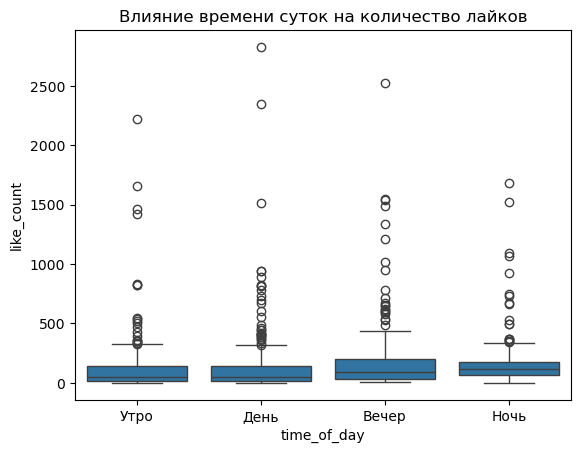

In [60]:
# Визуализируем зависимость числа лайков от времени суток
periods_order = ['Утро', 'День', 'Вечер', 'Ночь']
sns.boxplot(x='time_of_day', y='like_count', data=data, order=periods_order)
plt.title('Влияние времени суток на количество лайков')
plt.show()

In [61]:
# Проверим гомогенность дисперсий в группах - условие для применимости дисперсионного анализа
# Проведение теста Левена
stat, p_value = ss.levene(
    data.query("time_of_day == 'Утро'").like_count, 
    data.query("time_of_day == 'День'").like_count, 
    data.query("time_of_day == 'Вечер'").like_count,
    data.query("time_of_day == 'Ночь'").like_count
)

# Вывод результатов
print(f'Statistic: {stat:.3f}, p-value: {p_value:.3f}')

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: дисперсии не равны. Применяем ANOVA Уэлча.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что дисперсии равны. Применяем ANOVA.")

Statistic: 1.677, p-value: 0.170
Не отвергаем нулевую гипотезу: считаем, что дисперсии равны. Применяем ANOVA.


In [62]:
# Проверим, есть ли отличия между группами с помощью дисперсионного анализа
stat, p_value = ss.f_oneway(
    data.query("time_of_day == 'Утро'").like_count, 
    data.query("time_of_day == 'День'").like_count, 
    data.query("time_of_day == 'Вечер'").like_count,
    data.query("time_of_day == 'Ночь'").like_count
)

# Вывод результатов
print(f'Statistic: {stat:.3f}, p-value: {p_value:.3f}')

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: делаем вывод, что среднее хотя бы одной из групп значимо отличается от средних в других группах.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что различий между группами нет.")

Statistic: 3.349, p-value: 0.019
Отвергаем нулевую гипотезу: делаем вывод, что среднее хотя бы одной из групп значимо отличается от средних в других группах.


In [63]:
# Чтобы выявить отличающиеся группы, сравним их попарно с помощью критерия Тьюки
pg.pairwise_tukey(data=data, dv="like_count", between="time_of_day")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Вечер,День,189.200000,127.011173,62.188827,22.170507,2.805025,0.026334,0.227140
1,Вечер,Ночь,189.200000,168.072165,21.127835,25.532246,0.827496,0.841437,0.078994
2,Вечер,Утро,189.200000,130.582960,58.617040,24.624615,2.380425,0.081508,0.209445
3,День,Ночь,127.011173,168.072165,-41.060992,23.232786,-1.767373,0.289765,-0.167849
4,День,Утро,127.011173,130.582960,-3.571786,22.231473,-0.160664,0.998524,-0.013939
5,Ночь,Утро,168.072165,130.582960,37.489205,25.585202,1.465269,0.459017,0.154964


Только при одном сравнении p-value меньше 0.05. Можем сделать вывод, что статистически значимо различаются только среднее число лайков вечером и днём (вечером больше).
___
Проверим, есть ли разница между лайками ночью или вечером и днём или утром с помощью t-теста.

In [64]:
# Проверим гомогенность дисперсий в группах - условие для применимости t-теста
# Проведение теста Левена
stat, p_value = ss.levene( 
    data.query("time_of_day == 'Вечер' | time_of_day == 'Ночь'").like_count,
    data.query("time_of_day == 'Утро' | time_of_day == 'День'").like_count
)

# Вывод результатов
print(f'Statistic: {stat:.3f}, p-value: {p_value:.3f}')

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: дисперсии не равны. Применяем t-тест Уэлча.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что дисперсии равны. Применяем t-тест.")

Statistic: 2.087, p-value: 0.149
Не отвергаем нулевую гипотезу: считаем, что дисперсии равны. Применяем t-тест.


In [65]:
# Выполнение t-теста
t_statistic, p_value = ss.ttest_ind(
    data.query("time_of_day == 'Вечер' | time_of_day == 'Ночь'").like_count, 
    data.query("time_of_day == 'Утро' | time_of_day == 'День'").like_count, 
    equal_var=True
)

# Вывод результатов
print(f"T-статистика: {t_statistic}, P-значение: {p_value}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: считаем, что различия между группами есть.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что различий между группами нет.")

T-статистика: 3.057557189222291, P-значение: 0.0022909330833397533
Отвергаем нулевую гипотезу: считаем, что различия между группами есть.


Делаем вывод: статистически значимо на число лайков влияет, сделан ли пост утром/днём, либо вечером/ночью (вечером/ночью лайков больше).

### Проверка зависимости числа лайков от дня недели
Проверим, есть ли зависимость числа лайков от дня недели. Воспользуемся дисперсионным анализом.

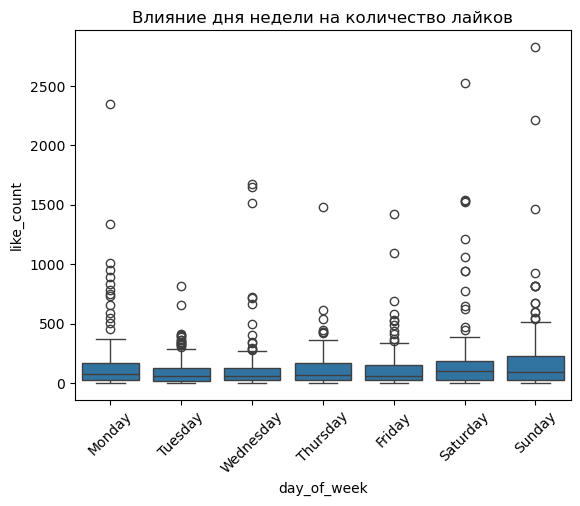

In [66]:
# Визуализируем зависимость числа лайков от дня недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='day_of_week', y='like_count', data=data, order=days_order)
plt.title('Влияние дня недели на количество лайков')
plt.xticks(rotation=45)
plt.show()

In [67]:
# Проверим гомогенность дисперсий в группах
# Проведение теста Левена
stat, p_value = ss.levene(
    data.query("day_of_week == 'Monday'").like_count, 
    data.query("day_of_week == 'Tuesday'").like_count, 
    data.query("day_of_week == 'Wednesday'").like_count,
    data.query("day_of_week == 'Thursday'").like_count,
    data.query("day_of_week == 'Friday'").like_count,
    data.query("day_of_week == 'Saturday'").like_count,
    data.query("day_of_week == 'Sunday'").like_count
)

# Вывод результатов
print(f'Statistic: {stat:.3f}, p-value: {p_value:.3f}')

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: дисперсии не равны. Применяем ANOVA Уэлча.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что дисперсии равны. Применяем ANOVA.")

Statistic: 2.519, p-value: 0.020
Отвергаем нулевую гипотезу: дисперсии не равны. Применяем ANOVA Уэлча.


In [68]:
res = pg.welch_anova(data=data, dv="like_count", between="day_of_week")

# Вывод результатов
print(f'Statistic: {res['F'].values[0]:.3f}, p-value: {res['p-unc'].values[0]:.3f}')

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: делаем вывод, что среднее хотя бы одной из групп значимо отличается от средних в других группах.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что различий между группами нет.")

Statistic: 3.033, p-value: 0.006
Отвергаем нулевую гипотезу: делаем вывод, что среднее хотя бы одной из групп значимо отличается от средних в других группах.


In [69]:
# Чтобы выявить отличающиеся группы, сравним их попарно с помощью критерия Тьюки
pg.pairwise_tukey(data=data, dv="like_count", between="day_of_week")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Friday,Monday,122.743056,161.893082,-39.150026,29.916571,-1.308640,0.848029,-0.164003
1,Friday,Saturday,122.743056,188.187500,-65.444444,29.872107,-2.190821,0.301334,-0.242457
2,Friday,Sunday,122.743056,203.318841,-80.575785,30.979476,-2.600941,0.126706,-0.278893
3,Friday,Thursday,122.743056,119.224000,3.519056,31.791439,0.110692,1.000000,0.019516
4,Friday,Tuesday,122.743056,105.878571,16.864484,30.866274,0.546373,0.998113,0.104350
5,Friday,Wednesday,122.743056,137.731343,-14.988288,31.214692,-0.480168,0.999093,-0.066835
6,Monday,Saturday,161.893082,188.187500,-26.294418,29.121054,-0.902935,0.972134,-0.086677
7,Monday,Sunday,161.893082,203.318841,-41.425759,30.255924,-1.369178,0.818195,-0.128744
8,Monday,Thursday,161.893082,119.224000,42.669082,31.086792,1.372579,0.816438,0.179934
9,Monday,Tuesday,161.893082,105.878571,56.014510,30.140005,1.858477,0.508650,0.253151


Только при одном сравнении p-value меньше 0.05. Можем сделать вывод, что статистически значимо различаются только среднее число лайков в воскресенье и во вторник (в воскресенье больше).
___
Проверим, есть ли разница между лайками в будни и в выходные с помощью t-теста.

In [70]:
# Проверим гомогенность дисперсий в группах - условие для применимости t-теста
# Проведение теста Левена
stat, p_value = ss.levene( 
    data.query("day_of_week == 'Saturday' | day_of_week == 'Sunday'").like_count,
    data.query("day_of_week != 'Saturday' & day_of_week != 'Sunday'").like_count
)

# Вывод результатов
print(f'Statistic: {stat:.3f}, p-value: {p_value:.3f}')

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: дисперсии не равны. Применяем t-тест Уэлча.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что дисперсии равны. Применяем t-тест.")

Statistic: 10.810, p-value: 0.001
Отвергаем нулевую гипотезу: дисперсии не равны. Применяем t-тест Уэлча.


In [71]:
# Выполнение t-теста
t_statistic, p_value = ss.ttest_ind(
    data.query("day_of_week == 'Saturday' | day_of_week == 'Sunday'").like_count, 
    data.query("day_of_week != 'Saturday' & day_of_week != 'Sunday'").like_count, 
    equal_var=False
)

# Вывод результатов
print(f"T-статистика: {t_statistic}, P-значение: {p_value}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: считаем, что различия между группами есть.")
else:
    print("Не отвергаем нулевую гипотезу: считаем, что различий между группами нет.")

T-статистика: 3.005742657441415, P-значение: 0.0028170592950059635
Отвергаем нулевую гипотезу: считаем, что различия между группами есть.


Делаем вывод: статистически значимо на число лайков влияет, сделан ли пост в будни, либо в выходные (в выходные лайков больше).

### Проверка зависимости числа лайков от времени между постами
Проверим, есть ли зависимость числа лайков от дня недели. Воспользуемся линейной регрессией.

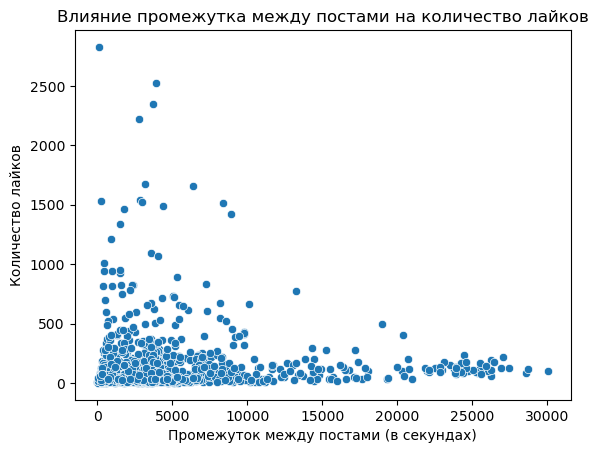

In [72]:
# Визуализируем зависимость числа лайков от времени с последнего поста
sns.scatterplot(x='time_since_next_post', y='like_count', data=data)
plt.title('Влияние промежутка между постами на количество лайков')
plt.xlabel('Промежуток между постами (в секундах)')
plt.ylabel('Количество лайков')
plt.show()

In [73]:
# Определяем переменные
X = data.dropna()['time_since_next_post']
Y = data.dropna()['like_count']

# Добавляем константу для модели
X = sm.add_constant(X)

# Создаем модель
model = sm.OLS(Y, X).fit()

# Выводим результаты
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3848
Date:                Thu, 19 Sep 2024   Prob (F-statistic):              0.535
Time:                        11:49:19   Log-Likelihood:                -6978.2
No. Observations:                 999   AIC:                         1.396e+04
Df Residuals:                     997   BIC:                         1.397e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  154.4011 

P-value > 0.05 (0.535), значит мы не можем отклонить нулевую гипотезу и считаем, что связи между переменными нет.  
Кроме того, коэффициент детерминации R-squared практически равен 0 - это значит, что модель не объясняет вариацию зависимой переменной.

## Анализ совместного влияния дня недели и времени суток на число лайков
Введём новые группы: является ли день выходным, и опубликован ли пост поздно (вечером/ночью). Посмотрим их совместное влияние на число лайков с помощью многофакторного дисперсионного анализа. 

In [74]:
# Добавим столбцы, показывающие, является ли день выходным, а пост поздним
data['is_weekend'] = np.where(
    (data.day_of_week == 'Saturday') | (data.day_of_week == 'Sunday'),
    'weekend',
    'weekday'
)
data['is_late_post'] = np.where(
    (data.time_of_day == 'Вечер') | (data.time_of_day == 'Ночь'),
    'late_post',
    'early_post'
)

In [81]:
# Выполним многофакторный дисперсионный анализ (равенство дисперсий мы проверяли ранее)
# Модель OLS
model = ols('like_count ~ is_weekend * is_late_post', data=data).fit()

# Выполнение ANOVA Уэлча
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                               sum_sq     df          F    PR(>F)
is_weekend               8.952197e+05    1.0  13.358294  0.000271
is_late_post             6.532186e+05    1.0   9.747200  0.001848
is_weekend:is_late_post  4.569662e+04    1.0   0.681876  0.409139
Residual                 6.674796e+07  996.0        NaN       NaN


Можем сделать вывод, что факторы влияют на зависимую переменную (p-value < 0.05), а вот их совместное влияние статистически не значимо (p-value > 0.05).

## Выводы
Статистически значимого влияния времени с последнего поста на число лайков нет.  
Важно, сделан ли пост в выходные, или в будни - больше лайков в выходные; и поздно (вечером/ночью) или рано (утром/днём) - больше лайков поздно.